<a href="https://colab.research.google.com/github/RiniVarghese/Gesture-Recognition-CaseStudy-/blob/Master/Gesture_Recognition_Assignment_Upgrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Name - Gesture Recognition**

# ***Problem Statement ***

We want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
- The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
    -- Thumbs up:  Increase the volume

    -- Thumbs down: Decrease the volume

    -- Left swipe: 'Jump' backwards 10 seconds

    -- Right swipe: 'Jump' forward 10 seconds  
    
    -- Stop: Pause the movie

# **Objective:**

To build a gesture recognition model using neural network which should have generators that are able to take batches of data without error and with optimized number of parameters so that the inference or prediction time should be less.
The architecture we are going to use is:

*   3D Convs
*   CNN + RNN stacked



In [3]:
# Importing the necessary libraries

import numpy as np
import os
import datetime
import imageio
from imageio import imread
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
# Use tf.keras for Keras-related functionality
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras.layers import Dropout

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
project_folder="/content/drive/MyDrive/Video Gesture Assignment /Project_data"

In [7]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Video Gesture Assignment /Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Video Gesture Assignment /Project_data/val.csv').readlines())
batch_size = 64
train_doc

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n',
       'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180907_1

 Generator Code

In [8]:
def generator(source_path, folder_list, batch_size,frame_count, img_y, img_z):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,frame_count)).astype(int)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frame_count, img_y, img_z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # Cropped image of above dimension

                    #image = image.crop((0, 0, 120, 120))
                    image_resized=resize(image,(img_y, img_z,3))


                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =(image_resized[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image_resized[:,:,2])/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        remain_seq=len(t)%batch_size
        if (remain_seq != 0):
            batch_size = remain_seq if remain_seq else batch_size

            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,frame_count, img_y, img_z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        # Cropped image of above dimension

                        #image = image.crop((0, 0, 120, 120))
                        image_resized=resize(image,(img_y, img_z,3))


                        #crop the images and resize them. Note that the images are of 2 different shape
                        #and the conv3D will throw error if the inputs in a batch have different shapes

                        batch_data[folder,idx,:,:,0] =(image_resized[:,:,0])/255#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] =(image_resized[:,:,1])/255#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] =(image_resized[:,:,2])/255#normalise and feed in the image

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels

In [9]:
#Date time to save models with timestamp as experimenting with multiple models
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Video Gesture Assignment /Project_data/train'
val_path = '/content/drive/MyDrive/Video Gesture Assignment /Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
#Choosing epochs as 30
num_epochs = 30
print ('# epochs =', num_epochs)
channels=3
num_classes=5
total_frames=30

# training sequences = 663
# validation sequences = 100
# epochs = 30


**Model**

The model using different functionalities that Keras provides.

-Using Conv3D and MaxPooling3D for a 3D convolution model.

-using TimeDistributed while building a Conv2D + RNN model.

**Conv3D - Model 1**



In [10]:
# Model 1
def define_model(Input_shape):
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same',input_shape=Input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv3D(32, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(5,activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
frame_count=10
img_y =100
img_z =100
Input_shape = (frame_count, img_y, img_z, 3)
model_1 = define_model(Input_shape)
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 10, 100, 100, 16   64        
 Normalization)              )                                   
                                                                 
 activation (Activation)     (None, 10, 100, 100, 16   0         
                             )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 100, 100, 32   13856     
                             )                                   
                                                                 
 activation_1 (Activation)   (None, 10, 100, 100, 32   0

Creating the Model.Fit

In [11]:
def model_train_fit(model,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs):

    train_generator = generator(train_path, train_doc, batch_size, frame_count, img_y, img_z)
    val_generator = generator(val_path, val_doc, batch_size,frame_count, img_y, img_z)

    model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
      verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
      min_lr = 0)
    callbacks_list = [checkpoint, LR]

    #The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

    model_tr = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return model_tr

In [ ]:
num_epochs = 10
history = model_train_fit(model_1,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 33.5810 - categorical_accuracy: 0.2459  
Epoch 1: saving model to Gesture_recog_2023-09-2812_44_11.886177/model-00001-33.58096-0.24585-25.39012-0.23000.h5
11/11 [==============================] - 2365s 234s/step - loss: 33.5810 - categorical_accuracy: 0.2459 - val_loss: 25.3901 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 8.1322 - categorical_accuracy: 0.3202
Epoch 2: saving model to Gesture_recog_2023-09-2812_44_11.886177/model-00002-8.13224-0.32016-23.36451-0.23438.h5
11/11 [==============================] - 108s 11s/step - loss: 8.1322 - categorical_accuracy: 0.3202 - val_loss: 23.3645 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 3.2918 - categorical_accuracy: 0.3360
Epoch 3: saving model to Gesture_recog_2023-09-2812_44_11.886177/model-00003-3.29175-0.33597-8.72275-0.28571.h5

In [12]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

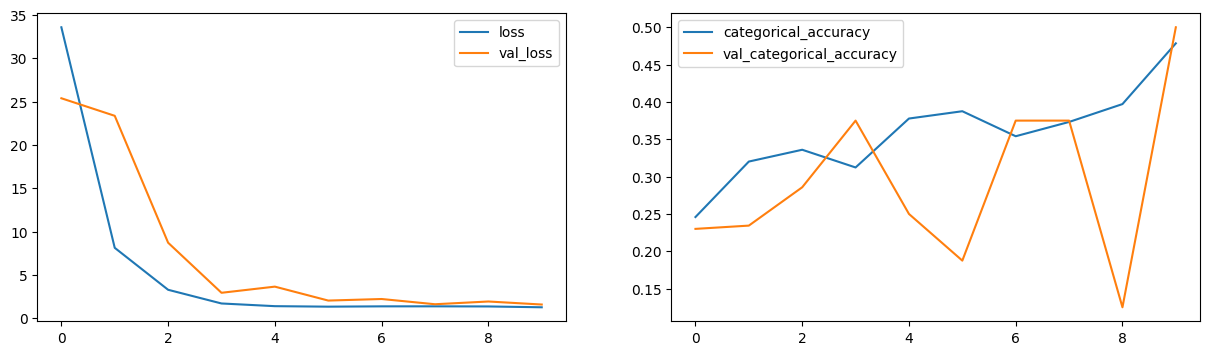

In [ ]:
plot(history)

Model 1  Conclusion-

Training Accuracy : 47% , Validation Accuracy :50 %

Model Analysis : Accuracy of the Model is very Low

**Conv3D MOdel 2**

Batch size = 40 ,Epoch = 15,
Image Size - 160 *160


In [ ]:
Input_shape = (20, 160, 160, 3)
dense_neurons=64
dropout=0.25
filtersize = (3,3,3)
model_2 = Sequential()
model_2.add(Conv3D(16, (3,3,3), padding='same',input_shape=Input_shape))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_2.add(Dropout(0.5))

model_2.add(Conv3D(32, filtersize, padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(64, filtersize, padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Conv3D(128, filtersize, padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_2.add(Flatten())
model_2.add(Dense(dense_neurons,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(dropout))

model_2.add(Dense(dense_neurons,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(dropout))


model_2.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam()
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, 20, 160, 160, 16   64        
 chNormalization)            )                                   
                                                                 
 activation_5 (Activation)   (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 10, 80, 80, 16)    0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 80, 80, 16)   

In [ ]:
num_epochs = 15
batch_size = 40
frame_count = 20
img_y = 160
img_z = 160
history =  model_train_fit(model_2,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.7318 - categorical_accuracy: 0.3801  
Epoch 1: saving model to Gesture_recog_2023-09-2816_38_48.308831/model-00001-1.73178-0.38009-1.54573-0.36000.h5
17/17 [==============================] - 3416s 213s/step - loss: 1.7318 - categorical_accuracy: 0.3801 - val_loss: 1.5457 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.3938 - categorical_accuracy: 0.4834
Epoch 2: saving model to Gesture_recog_2023-09-2816_38_48.308831/model-00002-1.39381-0.48338-2.57087-0.20000.h5
17/17 [==============================] - 185s 12s/step - loss: 1.3938 - categorical_accuracy: 0.4834 - val_loss: 2.5709 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.1943 - categorical_accuracy: 0.5448
Epoch 3: saving model to Gesture_recog_2023-09-2816_38_48.308831/model-00003-1.19426-0.54476-4.66281-0.13333.h5
17/17 

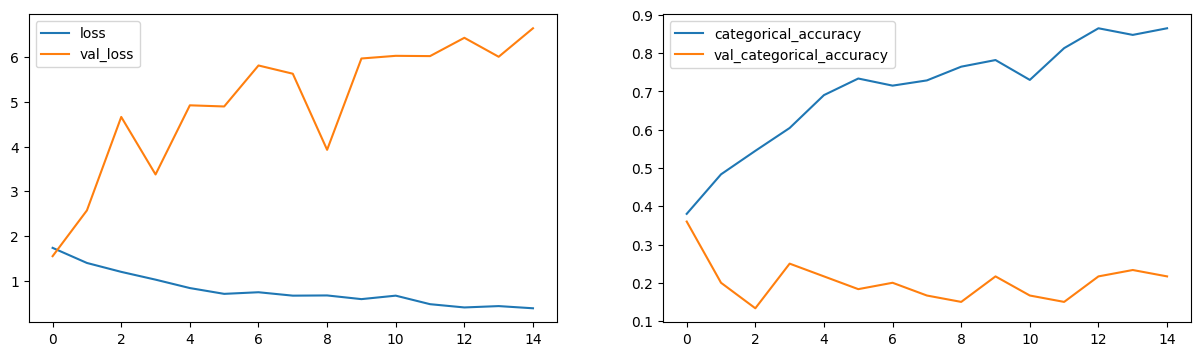

In [ ]:
plot(history)

Model 2 Conclusion -

Training Accuracy : 86% , Validation Accuracy : 21%

 Model Analysis : Model is highly overfitting

**CONV3D - Model 3**

Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 20

In [13]:
Input_shape = (16, 120, 120, 3)
dense_neurons=256
dropout=0.5
filtersize = (2,2,2)
model_3 = Sequential()
model_3.add(Conv3D(32, filtersize, padding='same',input_shape=Input_shape))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_3.add(Dropout(0.5))

model_3.add(Conv3D(64, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(128, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Conv3D(256, filtersize, padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_3.add(Flatten())
model_3.add(Dense(dense_neurons,activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(dropout))

model_3.add(Dense(dense_neurons,activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(dropout))


model_3.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
print (model_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 32   800       
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 16, 120, 120, 32   128       
 Normalization)              )                                   
                                                                 
 activation (Activation)     (None, 16, 120, 120, 32   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 60, 60, 32)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 60, 60, 32)     0

In [15]:
num_epochs = 20
batch_size = 30
frame_count = 16
img_y = 120
img_z = 120
history =  model_train_fit(model_3,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.9838 - categorical_accuracy: 0.3635  
Epoch 1: saving model to Gesture_recog_2023-10-0207_18_44.432890/model-00001-1.98377-0.36350-5.19096-0.16000.h5
23/23 [==============================] - 5633s 255s/step - loss: 1.9838 - categorical_accuracy: 0.3635 - val_loss: 5.1910 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.7673 - categorical_accuracy: 0.4058
Epoch 2: saving model to Gesture_recog_2023-10-0207_18_44.432890/model-00002-1.76728-0.40580-7.24062-0.20000.h5
23/23 [==============================] - 50s 2s/step - loss: 1.7673 - categorical_accuracy: 0.4058 - val_loss: 7.2406 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 2.4346 - categorical_accuracy: 0.2464
Epoch 3: saving model to Gesture_recog_2023-10-0207_18_44.432890/model-00003-2.43464-0.24638-6.67602-0.25000.h5
23/23 [=

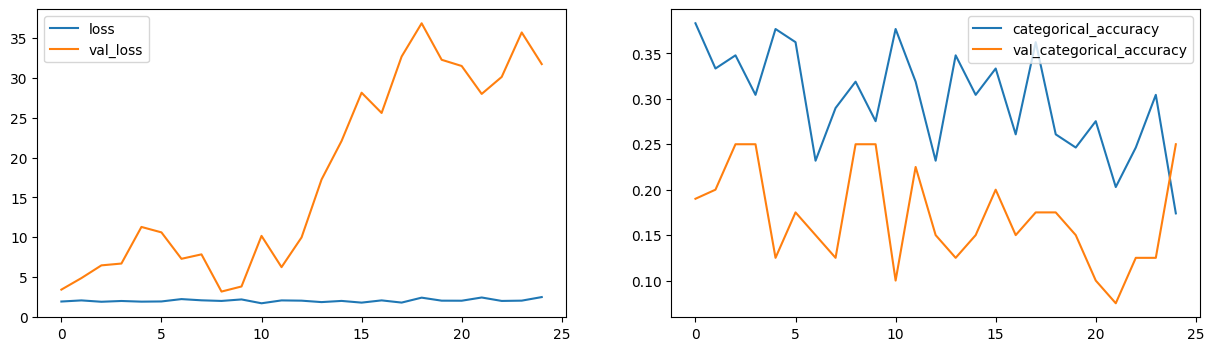

In [ ]:
plot(history)

Model 3 Conclusion

Training Accuracy : 28% , Validation Accuracy : 15%

Model Analysis : Accuracy of the Model is very Low

# **CONV3D - Model 4**

Image size =120 * 120 , Batch size - 20 , num_epochs=25

In [ ]:
Input_shape = (16, 120, 120, 3)
dense_neurons=64
dropout=0.25
filtersize = (3,3,3)
model_4 = Sequential()
model_4.add(Conv3D(16, filtersize, padding='same',input_shape=Input_shape))
model_4.add(BatchNormalization())
model_4.add(Activation('relu'))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_4.add(Dropout(0.5))

model_4.add(Conv3D(32, filtersize, padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(64, filtersize, padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Conv3D(128, filtersize, padding='same'))
model_4.add(Activation('relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_4.add(Flatten())
model_4.add(Dense(dense_neurons,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(dropout))

model_4.add(Dense(dense_neurons,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(dropout))


model_4.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 batch_normalization_10 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 8, 60, 60, 16)     0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 8, 60, 60, 16)    

In [ ]:
num_epochs = 25
batch_size = 20
frame_count = 16
img_y = 120
img_z = 120
history =  model_train_fit(model_4,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.4892 - categorical_accuracy: 0.4329
Epoch 1: saving model to Gesture_recog_2023-09-2900_57_46.226475/model-00001-1.48922-0.43288-2.93921-0.16000.h5
34/34 [==============================] - 132s 4s/step - loss: 1.4892 - categorical_accuracy: 0.4329 - val_loss: 2.9392 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.8027 - categorical_accuracy: 0.4118
Epoch 2: saving model to Gesture_recog_2023-09-2900_57_46.226475/model-00002-1.80271-0.41176-2.70274-0.23000.h5
34/34 [==============================] - 39s 1s/step - loss: 1.8027 - categorical_accuracy: 0.4118 - val_loss: 2.7027 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.6942 - categorical_accuracy: 0.3627
Epoch 3: saving model to Gesture_recog_2023-09-2900_57_46.226475/model-00003-1.69422-0.36275-4.55714-0.17000.h5
34/34 [======

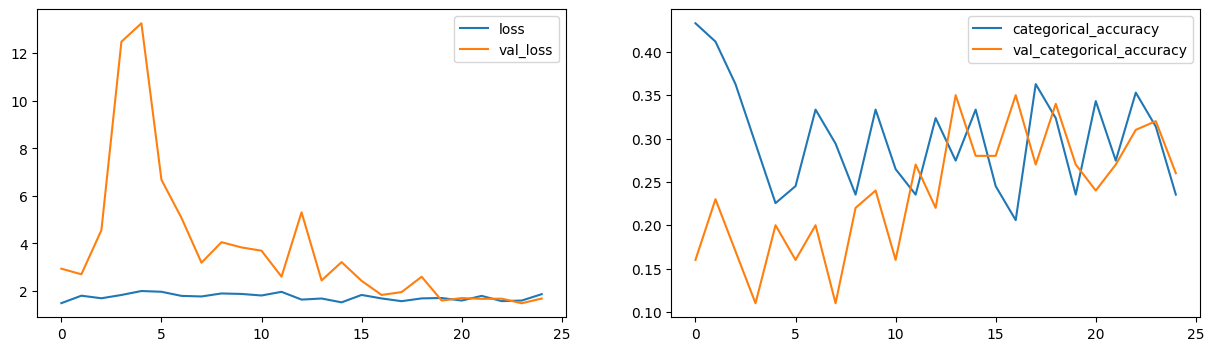

In [ ]:
plot(history)

Model 4 Conclusion

Accuracy is very low again for this model

# **Conv2D RNN + LSTM Model**

Batch size =20 , No. of Epochs = 20

In [ ]:
Input_shape = (18, 120, 120, 3)
dense_neurons=128
dropout=0.25
lstm_cells=128

model_5 = Sequential()
model_5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))


model_5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Flatten()))
model_5.add(LSTM(lstm_cells))
model_5.add(Dropout(dropout))

model_5.add(Dense(dense_neurons,activation='relu'))
model_5.add(Dropout(dropout))


model_5.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam()
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 18, 120, 120, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 18, 120, 120, 16   64        
 stributed)                  )                                   
                                                                 
 time_distributed_2 (TimeDi  (None, 18, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 18, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 18, 60, 60, 32)   

In [ ]:
num_epochs = 20
batch_size = 20
frame_count = 18
img_y = 120
img_z = 120
rnn_history =  model_train_fit(model_5,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4817 - categorical_accuracy: 0.3725 
Epoch 1: saving model to Gesture_recog_2023-09-2900_57_46.226475/model-00001-1.48170-0.37255-1.71532-0.28000.h5
34/34 [==============================] - 2110s 64s/step - loss: 1.4817 - categorical_accuracy: 0.3725 - val_loss: 1.7153 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3875 - categorical_accuracy: 0.3824
Epoch 2: saving model to Gesture_recog_2023-09-2900_57_46.226475/model-00002-1.38752-0.38235-2.63411-0.23000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.3875 - categorical_accuracy: 0.3824 - val_loss: 2.6341 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.6019 - categorical_accuracy: 0.3137
Epoch 3: saving model to Gesture_recog_2023-09-2900_57_46.226475/model-00003-1.60190-0.31373-1.77072-0.27000.h5
34/34 [===

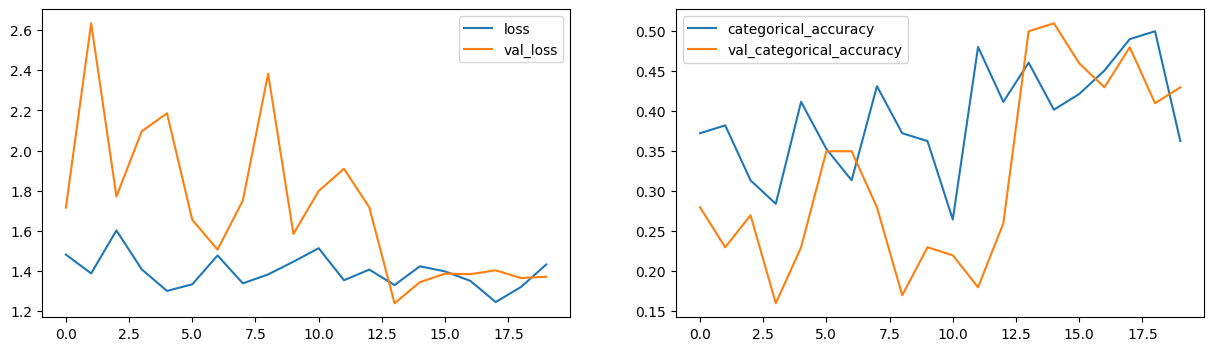

In [ ]:
plot(rnn_history)

Model 5 -

Training Accuracy : 36% , Validation Accuracy : 43%
Model Analysis : Accuracy of the Model is very Low

**Model 6**

Conv2D layers + LSTM Layer + dropout + L2 regularization

In [ ]:
from keras import regularizers

batch_size = 10 #experiment with the batch size
num_epochs = 10
dropout = 0.25
nb_classes = 5
frames = 15
Input_shape = (15, 120, 120, 3)
model_6 = Sequential()

model_6.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=Input_shape))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_6.add(Dropout(dropout))

model_6.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_6.add(Dropout(dropout))

model_6.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_6.add(Dropout(dropout))

model_6.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_6.add(Dropout(dropout))

model_6.add(TimeDistributed(Flatten()))

model_6.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dropout(dropout))

## using LSTM as the RNN model along with softmax as our last layer.
model_6.add(LSTM(64, return_sequences=False))
model_6.add(Dropout(dropout))

model_6.add(Dense(nb_classes, activation='softmax')) #

optimiser = optimizers.Adam(learning_rate=0.001)
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeD  (None, 15, 60, 60, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 15, 60, 60, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, 15, 30, 30, 16)    0         
 istributed)                                                     
                                                                 
 dropout_7 (Dropout)         (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_22 (TimeD  (None, 15, 30, 30, 32)    4640      
 istributed)                                          

In [ ]:
num_epochs = 10
batch_size = 10
frame_count = 15
img_y = 120
img_z = 120
rnn_history =  model_train_fit(model_6,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 4.1328 - categorical_accuracy: 0.3710 
Epoch 1: saving model to Gesture_recog_2023-09-3001_22_04.086028/model-00001-4.13277-0.37104-3.84653-0.16000.h5
67/67 [==============================] - 4029s 61s/step - loss: 4.1328 - categorical_accuracy: 0.3710 - val_loss: 3.8465 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 2.8667 - categorical_accuracy: 0.4279
Epoch 2: saving model to Gesture_recog_2023-09-3001_22_04.086028/model-00002-2.86672-0.42786-3.41890-0.20000.h5
67/67 [==============================] - 48s 727ms/step - loss: 2.8667 - categorical_accuracy: 0.4279 - val_loss: 3.4189 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 2.5053 - categorical_accuracy: 0.3781
Epoch 3: saving model to Gesture_recog_2023-09-3001_22_04.086028/model-00003-2.50532-0.37811-2.60587-0.22000.h5
67/67 [

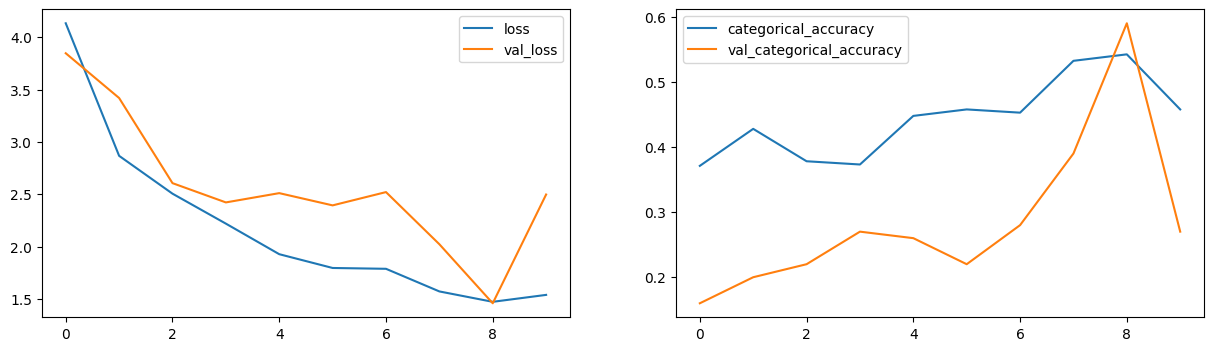

In [ ]:
plot(rnn_history)

Model 6 Conclusion -
Training Accuracy : 45% , Validation Accuracy : 25%
Model Analysis : Accuracy of the Model is very Low

**Model 7**

Batch Size = 5 , No of Epoch =15

Conv2D layers + LSTM Layer

In [ ]:
Input_shape = (20, 160, 160, 3)
dense_neurons=64
dropout=0.25
lstm_cells=64

model_7 = Sequential()

model_7.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=Input_shape))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_7.add(Dropout(dropout))

model_7.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_7.add(Dropout(dropout))

model_7.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_7.add(Dropout(dropout))

model_7.add(TimeDistributed(Conv2D(128, (2,2),padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model_7.add(Dropout(dropout))

model_7.add(TimeDistributed(Flatten()))

model_7.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(Dropout(dropout))

## using LSTM as the RNN model along with softmax as our last layer.
model_7.add(LSTM(64, return_sequences=False))
model_7.add(Dropout(dropout))

model_7.add(Dense(nb_classes, activation='softmax')) #

optimiser = optimizers.Adam(learning_rate=0.001)
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeD  (None, 20, 80, 80, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_33 (TimeD  (None, 20, 80, 80, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_34 (TimeD  (None, 20, 40, 40, 16)    0         
 istributed)                                                     
                                                                 
 dropout_13 (Dropout)        (None, 20, 40, 40, 16)    0         
                                                                 
 time_distributed_35 (TimeD  (None, 20, 40, 40, 32)    4640      
 istributed)                                          

In [ ]:
num_epochs = 15
batch_size = 5
frame_count = 20
img_y = 160
img_z = 160
history =  model_train_fit(model_7,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 4.9110 - categorical_accuracy: 0.3092  
Epoch 1: saving model to Gesture_recog_2023-09-3001_22_04.086028/model-00001-4.91100-0.30920-4.48922-0.18000.h5
17/17 [==============================] - 2155s 134s/step - loss: 4.9110 - categorical_accuracy: 0.3092 - val_loss: 4.4892 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 3.7730 - categorical_accuracy: 0.4169
Epoch 2: saving model to Gesture_recog_2023-09-3001_22_04.086028/model-00002-3.77301-0.41688-3.86247-0.10000.h5
17/17 [==============================] - 166s 10s/step - loss: 3.7730 - categorical_accuracy: 0.4169 - val_loss: 3.8625 - val_categorical_accuracy: 0.1000 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 3.1106 - categorical_accuracy: 0.4706
Epoch 3: saving model to Gesture_recog_2023-09-3001_22_04.086028/model-00003-3.11065-0.47059-3.75172-0.16667.h5
17/17 

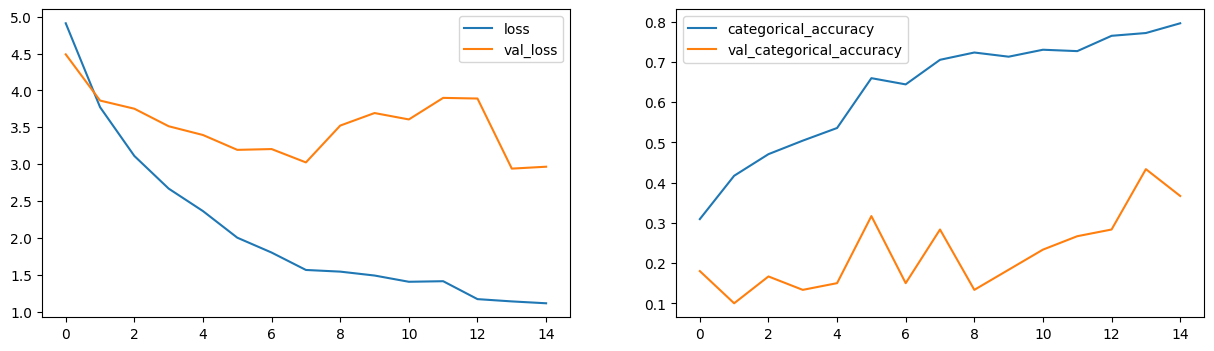

In [ ]:
plot(history)

Model 7 Conclusion -
Training Accuracy : 76% , Validation Accuracy : 28%
Model Analysis : Overfitting Model

**Model 8**

Conv2D layers + LSTM Layer

Using Transfer Learning - MobileNet

In [22]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

Input_shape = (18, 120, 120, 3)
model_8 = Sequential()
model_8.add(TimeDistributed(mobilenet_transfer,input_shape=Input_shape))

model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_8.add(TimeDistributed(Flatten()))


model_8.add(GRU(128))
model_8.add(Dropout(0.25))

model_8.add(Dense(128,activation='relu'))
model_8.add(Dropout(0.25))

model_8.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam()
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_8.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeD  (None, 18, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 18, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 18, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 18, 1024)          0         
 istributed)                                                     
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [23]:
num_epochs = 15
batch_size = 5
frame_count = 18
img_y = 120
img_z = 120
history =  model_train_fit(model_8,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Epoch 1/15
133/133 [==============================] - ETA: 0s - loss: 1.2064 - categorical_accuracy: 0.5189
Epoch 1: saving model to Gesture_recog_2023-10-0207_18_44.432890/model-00001-1.20637-0.51885-0.58272-0.75000.h5
133/133 [==============================] - 137s 919ms/step - loss: 1.2064 - categorical_accuracy: 0.5189 - val_loss: 0.5827 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 1.0541 - categorical_accuracy: 0.5739
Epoch 2: saving model to Gesture_recog_2023-10-0207_18_44.432890/model-00002-1.05409-0.57393-0.73763-0.71000.h5
133/133 [==============================] - 82s 622ms/step - loss: 1.0541 - categorical_accuracy: 0.5739 - val_loss: 0.7376 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 0.7618 - categorical_accuracy: 0.7043
Epoch 3: saving model to Gesture_recog_2023-10-0207_18_44.432890/model-00003-0.76181-0.70426-0.73633-0.64000.

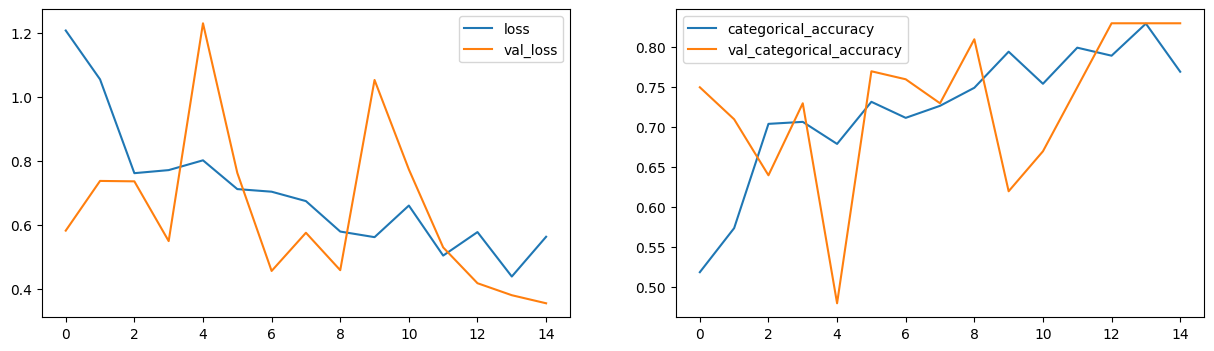

In [24]:
plot(history)

Model 8 Conclusion

Training Accuracy : 76% , Validation Accuracy : 83%
Model Analysis : This Model has performed better than the other models

## ***Final Conclusion ***

Model 8 with Conv2D layers + LSTM Layer and Using Transfer Learning - MobileNet has performed better compared to the other model